# Quinn <I>et al.</I> (Nature Communications, 2021): GLM and population modeling code

Please included the file DAButils.py in the same directory as this notebook, as well as the example dataset that is referenced below.

## Import relevant packages, and load dataset

In [1]:
# Import existing packages as well as utility functions in DAButils.py
import numpy as np
import scipy.io as sio  # for reading and writing matlab functions
from scipy.optimize import minimize
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
# Some custom utility functions so that this code can focus on the important steps
import DAButils as utils

In [2]:
# Load data from example recording
dirname = '/Users/dbutts/Projects/HN/SupportingCodeLowRes/' # fill in your working directory here
datafile = sio.loadmat(dirname+'PopAnalysis_Dataset_ki_0503.mat')

### Extract information about the (example) recording ###
expt_name = datafile['expt_name'][0]
channel_names = datafile['channel_names']
print( "Dataset: %s, %d units included."%(expt_name, len(channel_names)))
disparity_list = datafile['disp_list'][0,:]
near_far_indxs = datafile['near_far_indxs'][0,:]
print('All disparities presented:', disparity_list)
print('Near disparity: %0.1f\nFar disparity %0.1f'%(disparity_list[near_far_indxs[0]], 
                                                    disparity_list[near_far_indxs[1]]))
### Stimulus information ###
stim_true = datafile['stim_true']  # whether 'near' (-1) or 'far' (+1) (stimulus chosen on each side)
stim_strength = datafile['stim_strength']  # fraction of additional stim present at near/far disparity on each side
stim_hists = datafile['stim_hists'] # histograms of disparities on each trial
num_trials = stim_true.shape[0]
print( "%d trials present"%num_trials )

### Behavior-relevant trial information
relevant = datafile['relevant_stim'][0,:] # which side was cued to be 'relevant' on each trial
choices = datafile['choice'][:,0] # animals choice (decision) on each trial: near (-1) and far (+1)

### Recording:
spk_cnts = datafile['spk_counts']  # total spike count of each unit on each trial
num_cells0 = spk_cnts.shape[1]  # this will match the number of channel names

Dataset: ki_0503_V2b_py.mat, 19 units included.
All disparities presented: [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]
Near disparity: -0.2
Far disparity 0.2
848 trials present


### Format data for GLM (general linear model)

<p>Here we use a general linear model to predict the spike count on each trial using (1) "<b>stim</b>": the histogram of disparities presented during that trials; (2) "<b>choice</b>": the animals indication of its decision that it was a "near" or "far" trial; (3) "<b>drift</b>": an offset in the spike count over time that captures non-stationarities unrelated to these two variables.</p>
<p>Half the trials involve trials where the stimulus used for the decision was in the recorded neurons' receptive field (RF) and thus "relevant", and the other half were "irrelevant" trials. We assume the drift term is shared between these trials, but otherwise compute different disparity- and choice-tuning weights.</p>
<br>
\begin{equation}
R(t) = \sum_x f_r(x) n_t^{(r)}(x) + \sum_x f_i(x) n_t^{(i)}(x) + w_rc_t^{(r)} + w_ic_t^{(i)} + d(t)
\end{equation}
<br>
<p>Here 'r' is weights and values on the "relevant" trials and 'i' is for the irrelevant trials, and $f_{i,r}(x)$ are the disparity tuning curves, w_{r,i} are the choice weights, and $d(t)$ is the drift term.</p>
<p>We use a "design matrix" that organizes the data into a single matrix $\mathbf{X}$ that is the number of trials by the number of model parameters $N_{tr}\times M$, with each row having the data relevant to the spike count for a given trial:

In [3]:
# Disparity histograms into the design matrix for relevant (cols 1-11) and irrelevent (cols 12-22) trials
trR = np.where(relevant == 0)[0]
trI = np.where(relevant == 1)[0]

ND = len(disparity_list)
XstimR, XstimI = np.zeros([num_trials, ND]), np.zeros([num_trials, ND]) 
XstimR[trR, :] = stim_hists[trR, :]
XstimI[trI, :] = stim_hists[trI, :]

Xstim = np.concatenate((XstimR, XstimI), axis=1)

# Choice data organized by relevant/irrelevant trials 
Xchoice = np.zeros([num_trials, 2])
Xchoice[trR, 0] = choices[trR]
Xchoice[trI, 1] = choices[trI]

In [4]:
# Make tent-bases to model drift based on anchor points after each period of relevant-irrelevant trials
block_shifts = np.where(abs(np.diff(np.squeeze(relevant))) > 0)[0]
half_period=np.median(np.diff(block_shifts)).astype(int)
anchor_spacing = half_period*2

# This "tent-bases" is described more below in Appendix 1
Xdrift, num_drifts = utils.drift_design_matrix( num_trials, anchor_spacing )

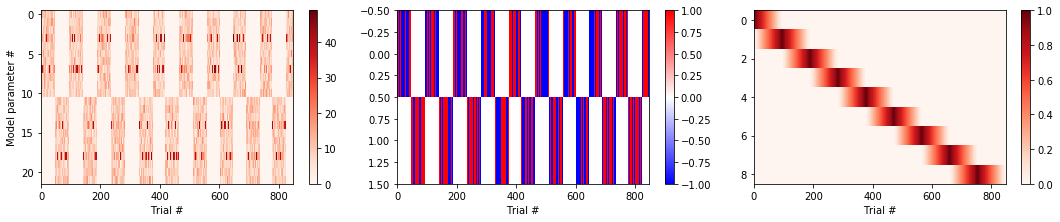

In [5]:
# Concatenate data to single design matrix that are the inputs (regressors) to the GLM
X = np.concatenate( (Xstim, Xchoice, Xdrift), axis=1 )
num_trials, num_params = X.shape
X.shape # this will be number of trials x number of parameters in the full model

# DISPLAY the three sections of the design matrices
utils.subplot_setup(1,3, full_width=True, row_height=3)
plt.subplot(1,3,1)
plt.imshow(Xstim.T, aspect='auto', cmap='Reds')
plt.xlabel('Trial #')
plt.ylabel('Model parameter #')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(Xchoice.T, aspect='auto', cmap='bwr')
plt.xlabel('Trial #')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(Xdrift.T, aspect='auto', cmap='Reds')
plt.xlabel('Trial #')
plt.colorbar()
plt.show()

### Fit GLM to each neuron

<p>Here we wrote a quick implementation to use scipy's 'minimize' routine to fit the model. In fact, we generally use much more sophisticated packages for fitting neural data (such as described in McFarland et al, PLoS CB, 2013) and available at http://neurotheory.umd.edu/Code. However, such 'custom code' is not necessary for the models here, and this this code is stripped down to illustrate only the methods used in this paper.</p>
<p>Because GLMs are 'convex' optimization problems, we will use simple gradient descent (the L-BFGS algorithm), which passes in the loss function and its gradient. The loss function here (to me minimized) is the mean-squared error plus smoothness regularization operating on the tuning curves and drift terms. The smoothness regularization is using a standard Laplacian penalty (see for example McFarland et al, 2013) and is the trickier bit to explain here, but see Appendix 2.</p>

In [6]:
def laplacian_smoothness_matrix( num_params ):
    """Makes laplacian to enforce smoothness: see below for how it is used"""
    Rmat = 2*np.eye(num_params) - np.eye(num_params, k=1) - np.eye(num_params, k=-1) 
    # no restrictions on the values on the edges (where slope is not defined)
    Rmat[0,:] = 0
    Rmat[-1,:] = 0
    return Rmat


def glm_loss(k, X, Rtarget, lambdas, Nstim, Ndrift):
    """This is a standard mean-squared error loss, with regularization penalties. Note that these 
    penalties are specific to the structure of this model, since smoothness is applied separately
    to each tuning curve, and also (with a different penalty weight) to the drift term.
    Inputs: 
        k = vector of model parameters
        X = design matrix such that predicted output R = X@k
        Rtarget = observed spike counts to compare prediction to
        lambdas = regularization weights as a length-2 list: [lambda_stim, lambda_drift]
        Nstim = number of parameters in the stimulus tuning curve
        Ndrift = number of parameters in the drfit term
    Output:
        Dictionary representing output of optimization code: see 'scipy.optimize.minimize' for full description.
        Here we will use the optimized parameters output['x'] only"""

    # MSE calc
    mse = np.mean(np.square(X@k - Rtarget))
    
    # Laplacian matrices for smoothness penalty
    T1 = laplacian_smoothness_matrix(Nstim)
    T2 = laplacian_smoothness_matrix(Ndrift)

    # Compute regularization penalties
    reg_penK = lambdas[0] * np.sum( np.square(T1 @ k[range(Nstim)]) + np.square(T1 @ k[range(Nstim, 2*Nstim)]) )
    reg_penD = lambdas[1] * np.sum(np.square(T2 @ k[range(2*Nstim+2, 2*Nstim+2+Ndrift)]))

    return mse + reg_penK + reg_penD


def glm_loss_grad(k, X, Rtarget, lambdas, Nstim, Ndrift):
    """Gradient calculation for the above loss function. See above for inputs"""
    T1 = laplacian_smoothness_matrix(Nstim)
    T2 = laplacian_smoothness_matrix(Ndrift)

    NT = len(Rtarget)  # number of time points (for mean calc)
    mse_grad = 2*X.T@(X@k - Rtarget) / NT
    
    # Piece-wise construction of regularization-gradient
    reg_grad = np.concatenate( 
        (2*lambdas[0]* T1.T @ (T1 @ k[range(Nstim)]), 
         2*lambdas[0]* T1.T @ (T1 @ k[range(Nstim,2*Nstim)]),
         np.zeros(2),
         2*lambdas[1] * T2.T @ (T2 @ k[range(2*Nstim+2, 2*Nstim+2+Ndrift)])), axis=0)

    return mse_grad + reg_grad

<h4>A note about picking training and testing indices</h4>
To judge performance, we leave out some trials for cross-validation (the testing set). This is not strictly necessary because the detailed model performance has little value given that it can explain the data to a certain degree. However, because of the number of possible conditions on each trial, it is important to distribute the different types of trials relatively evenly in the training set, which is accomplished by the function below. Small differences in choices of model parameters, as well as the types of trials available as a whole in a given recording, can influence the values for the angles found, but at much finer resolution than the confidence intervals (and for the most part, the figure 4 itself, which this code supports). 

In [7]:
# Make training and test sets for 5-fold cross validation (distributed over dataset) -- just do one fold here
fold_validation, fold_n = 5, 2

def balanced_validation_indices(stim, strength, relevant, num_folds=5, fold_n=None):
    # Choose training and cross-validation set to balance across trial types for stimuli in RF
    num_trials = len(relevant)
    zerostrengthRN = np.where((strength[:,0] == 0) & (relevant == 0) & (stim[:,0] < 0))[0]
    zerostrengthRF = np.where((strength[:,0] == 0) & (relevant == 0) & (stim[:,0] > 0))[0]
    zerostrengthIN = np.where((strength[:,0] == 0) & (relevant == 1) & (stim[:,0] < 0))[0]
    zerostrengthIF = np.where((strength[:,0] == 0) & (relevant == 1) & (stim[:,0] > 0))[0]
    somestrengthRN = np.where((strength[:,0] > 0) & (relevant == 0) & (stim[:,0] < 0))[0]
    somestrengthRF = np.where((strength[:,0] > 0) & (relevant == 0) & (stim[:,0] > 0))[0]
    somestrengthIN = np.where((strength[:,0] > 0) & (relevant == 1) & (stim[:,0] < 0))[0]
    somestrengthIF = np.where((stim_strength[:,0] > 0) & (relevant == 1) & (stim_true[:,0] > 0))[0]
    reordered = np.concatenate(
        (zerostrengthRN, zerostrengthRF, zerostrengthIN, zerostrengthIF,
         somestrengthRN, somestrengthRF, somestrengthIN, somestrengthIF), axis=0)
    if fold_n is None:
        fold_n = int(num_folds//2) # pick a middle fold

    test_inds = np.arange(fold_n, num_trials, num_folds)
    train_inds = np.setdiff1d( np.arange(num_trials), test_inds)
    return train_inds, test_inds


train_inds, test_inds = balanced_validation_indices(stim_true, stim_strength, relevant, num_folds=5, fold_n=2)
# print(len(train_inds), len(test_inds), test_inds[range(5)])

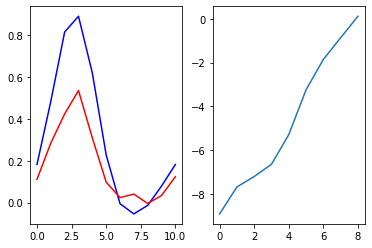

R2s: train = 0.691, test = 0.626


In [8]:
### Optimization  -- single neuron to demonstrate ###
# Model initialization (doesn't matter here since it is a convex optimization)
K0 = np.random.normal(size=num_params) 

cc = 8 # choose (arbritrarily) 9th neuron 
reg_lambdas = [4, 0.1]  # chosen by hand to result in smooth (but not flat) tuning and drift weights

# Use scipy's mimimization to find optimal model parameters
opt_out = minimize(glm_loss, 
                   K0, 
                   args=(X[train_inds,:], spk_cnts[train_inds, cc], reg_lambdas, ND, num_drifts), 
                   method='L-BFGS-B', 
                   jac=glm_loss_grad, 
                   options={'disp': True})

# Plot results
plt.subplot(1,2,1)
plt.plot(opt_out['x'][range(ND)],'b')
plt.plot(opt_out['x'][range(ND,2*ND)],'r')
plt.subplot(1,2,2)
plt.plot(opt_out['x'][range(ND*2+2,ND*2+2+num_drifts)])
plt.show()

# Compute model performance R2 on train and test set -- set reg penalities to zero to isolate MSE 
trainMSE = glm_loss( opt_out['x'], X[train_inds,:], spk_cnts[train_inds,cc], [0,0], ND, num_drifts)
testMSE = glm_loss( opt_out['x'], X[test_inds,:], spk_cnts[test_inds,cc], [0,0], ND, num_drifts)
# R2 calculations based on normalization by variance in data
var_train, var_test = np.var(spk_cnts[train_inds, cc]), np.var(spk_cnts[test_inds, cc])
R2train = 1-trainMSE/var_train
R2test = 1-testMSE/var_train
print( "R2s: train = %5.3f, test = %5.3f"%(R2train, R2test))

Cell  0: tr 0.617 | te 0.540	Regs: [4.  0.1]


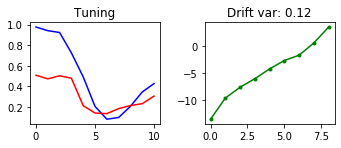

Cell  1: tr 0.653 | te 0.538	Regs: [4.  0.1]


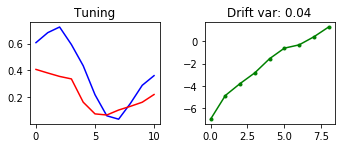

Cell  2: tr 0.679 | te 0.599	Regs: [4.  0.1]


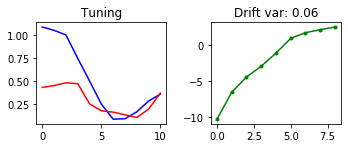

Cell  3: tr 0.641 | te 0.559	Regs: [4.  0.1]


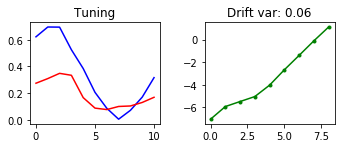

Cell  4: tr 0.618 | te 0.530	Regs: [4.  0.1]


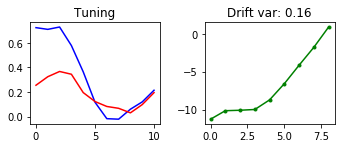

Cell  5: tr 0.573 | te 0.529	Regs: [4.  0.1]


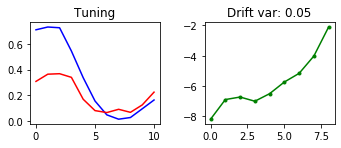

Cell  6: tr 0.531 | te 0.448	Regs: [4.  0.1]


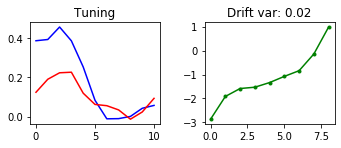

Cell  7: tr 0.613 | te 0.575	Regs: [4.  0.1]


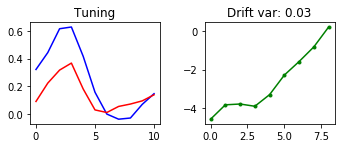

Cell  8: tr 0.691 | te 0.618	Regs: [4.  0.1]


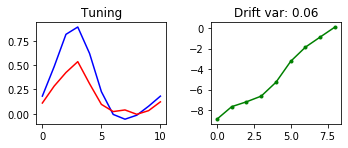

Cell  9: tr 0.736 | te 0.700	Regs: [4.  0.1]


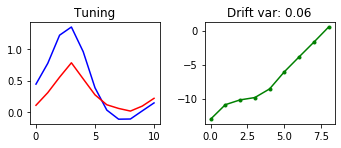

Cell 10: tr 0.722 | te 0.674	Regs: [4.  0.1]


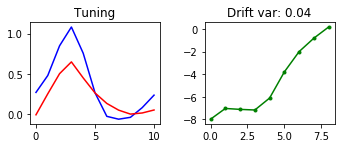

Cell 11: tr 0.675 | te 0.638	Regs: [8.  0.1]


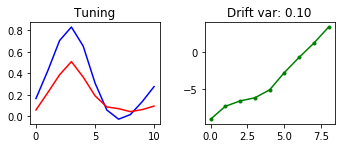

Cell 12: tr 0.666 | te 0.620	Regs: [4.  0.1]


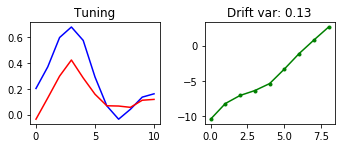

Cell 13: tr 0.647 | te 0.616	Regs: [8.  0.1]


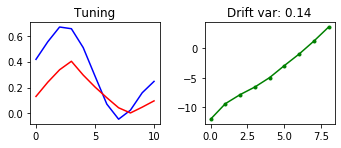

Cell 14: tr 0.415 | te 0.389	Regs: [4.  0.1]


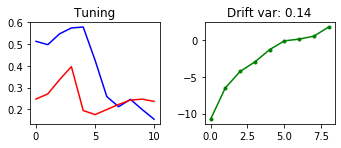

Cell 15: tr 0.675 | te 0.639	Regs: [8.  0.1]


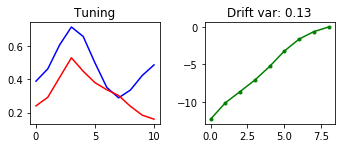

Cell 16: tr 0.361 | te 0.356	Regs: [8.  0.1]


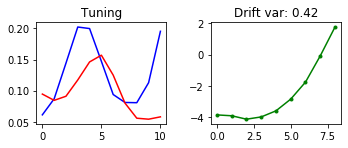

Cell 17: tr 0.340 | te 0.245	Regs: [4.  0.1]


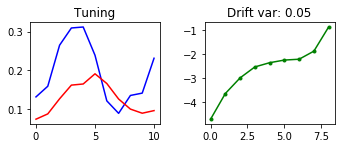

Cell 18: tr 0.266 | te 0.306	Regs: [4.  0.1]


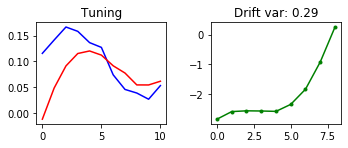

In [9]:
### Loop over all neurons to produce models for each (stored in single parameter matrix) ###
# Default regularization for all neurons: can be iteratively adjusted to get smooth 
RegLambdas = np.array([[4, 0.1]]*num_cells0)
## Potential adjustments: by eye and re-run -- almost no impact on results, but looks nicer
RegLambdas[11,0] *= 2
RegLambdas[13,0] *= 2
RegLambdas[15,0] *= 2
RegLambdas[16,0] *= 2

models = np.zeros( [num_cells0, num_params])
# compute variances for R2 calc across all neurons at ones
vars_train = np.var(spk_cnts[train_inds, :], axis=0)
vars_test = np.var(spk_cnts[test_inds, :], axis=0)

# the fraction of model variance explained by the drift term is an additional (more sensitive) inclusion 
# criteria that we apply to only use reliable models
drift_var_check = np.zeros(num_cells0) 

# Loop across all neurons in recording
for cc in range(num_cells0):

    K0 = np.random.normal(size=num_params) # initialization

    opt_output = minimize(glm_loss, 
                          K0, args=(X[train_inds,:], spk_cnts[train_inds,cc], RegLambdas[cc,:], ND, num_drifts), 
                          method='L-BFGS-B', 
                          jac=glm_loss_grad, 
                          options={'disp': False})
    
    models[cc, :] = opt_output['x']
    trainMSE = glm_loss( models[cc,:], X[train_inds,:], spk_cnts[train_inds, cc], [0,0], ND, num_drifts)
    testMSE = glm_loss( models[cc,:], X[test_inds,:], spk_cnts[test_inds,cc], [0,0], ND, num_drifts)
    R2train = 1 - trainMSE / vars_train[cc]
    R2test = 1 - testMSE / vars_test[cc]
    
    # Check to eliminate models where variance of drift > 1/2 of total variance (see below)
    drift_var_check[cc] = np.var(Xdrift@models[cc, range(ND*2+2,ND*2+2+num_drifts)]) / np.var(X@models[cc,:])

    print("Cell %2d: tr %0.3f | te %0.3f\tRegs:"%(cc, R2train, R2test), RegLambdas[cc,:] )
    
    utils.subplot_setup(1,2)
    plt.subplot(121)
    plt.plot(models[cc, range(ND)],'b')
    plt.plot(models[cc, range(ND,2*ND)],'r')
    plt.title('Tuning')

    plt.subplot(122)
    plt.plot(models[cc, range(ND*2+2,ND*2+2+num_drifts)],'g')
    plt.plot(models[cc, range(ND*2+2,ND*2+2+num_drifts)],'g.')
    plt.title("Drift var: %0.2f"%(drift_var_check[cc]) )
    plt.show()

In [10]:
# Check to eliminate models where variance of drift > 1/2 of total variance
drift_var_thresh = 0.5
keepers = np.where(drift_var_check < drift_var_thresh)[0]
model_pars = np.array( models[keepers,:])
num_cells = len(keepers)

print("Keeping %d/%d cells. Eliminating:"%(num_cells, num_cells0), 
      np.where(drift_var_check >= drift_var_thresh)[0])

Keeping 19/19 cells. Eliminating: []


### Compute angles between population vectors

We compute four population vectors from each dataset, spanning combinations of stimulus-driven and choice-driven activity for relevant and irrelevant trials:
<br>
$\vec{v}_{stim}$ represents the difference in population spike count driven by the near vs far stimuli
<br>
$\vec{v}_{choice}$ represents the difference in population spike count driven by near and far choices

In [11]:
# Section of model parameters corresponding to the tuning curves
tuningR = model_pars[:, range(ND)]
tuningI = model_pars[:, range(ND, 2*ND)]
# Extract "near" and "far" stimulus weights and take difference
VstimR = tuningR[:, near_far_indxs[1]] - tuningR[:, near_far_indxs[0]] 
VstimI = tuningI[:, near_far_indxs[1]] - tuningI[:, near_far_indxs[0]]
VchoiceR = 2*model_pars[:, 2*ND]   
VchoiceI = 2*model_pars[:, 2*ND+1]

Angles between vectors are simply computed from the normalized dot product, given
$ \vec{v}_1\cdot\vec{v}_2 = |v_1||v_2|\cos\theta$

In [12]:
def vector_angle( v1, v2 ):
    """Note that this returns an answer in degrees. 
    utils.vector_normalize simply returns a unit vector with same direction"""
    return np.arccos(utils.normalize_vector(v1)@utils.normalize_vector(v2))/np.pi*180

In [13]:
# Stimulus-choice angle
Thetas_StimChoice = [vector_angle(VstimR, VchoiceR), vector_angle(VstimR, VchoiceI)]

# Changes between relevant and irrlevant
ThetaStimRI = vector_angle(VstimR, VstimI)
ThetaChoiceRI = vector_angle(VchoiceR, VchoiceI)

print('\nStimulus-choice angles:\nRelevant: %0.1f \tIrrelevant: %0.1f'%(Thetas_StimChoice[0], Thetas_StimChoice[1] ))
print('\nRelevant-irrelevant angles:\nStim: %0.1f \tChoice: %0.1f'%(ThetaStimRI, ThetaChoiceRI ))


Stimulus-choice angles:
Relevant: 38.8 	Irrelevant: 57.0

Relevant-irrelevant angles:
Stim: 4.3 	Choice: 33.1


## Bootstrap confidence intervals

We used simple bootstrapping: resampling neurons with replacement to generate vectors of the same dimension. We reported mean and 95% confidence intervals

In [14]:
num_reps = 1000
ThetasSC_R = np.zeros(num_reps)
ThetasSC_I = np.zeros(num_reps)
ThetasRI_S = np.zeros(num_reps)
ThetasRI_C = np.zeros(num_reps)
for nn in range(num_reps):
    # Resample 4 vectors
    scramble = np.random.randint(num_cells, size=num_cells)
    VstimR_rsmp = VstimR[scramble]
    VstimI_rsmp = VstimI[scramble]
    VchoiceR_rsmp = VchoiceR[scramble]
    VchoiceI_rsmp = VchoiceI[scramble]
    ThetasSC_R[nn] = vector_angle(VstimR_rsmp, VchoiceR_rsmp)
    ThetasSC_I[nn] = vector_angle(VstimI_rsmp, VchoiceI_rsmp)
    ThetasRI_S[nn] = vector_angle(VstimR_rsmp, VstimI_rsmp)
    ThetasRI_C[nn] = vector_angle(VchoiceR_rsmp, VchoiceI_rsmp)

# Print out median and 5-95% percentile of resamples
ThetasSCR_ci = [np.median(ThetasSC_R), np.sort(ThetasSC_R)[50], np.sort(ThetasSC_R)[950]]
ThetasSCI_ci = [np.median(ThetasSC_I), np.sort(ThetasSC_I)[50], np.sort(ThetasSC_I)[950]]
ThetasRIS_ci = [np.median(ThetasRI_S), np.sort(ThetasRI_S)[50], np.sort(ThetasRI_S)[950]]
ThetasRIC_ci = [np.median(ThetasRI_C), np.sort(ThetasRI_C)[50], np.sort(ThetasRI_C)[950]]
print(" Stimulus-choice angles, Relevant:\t", ThetasSCR_ci)
print(" Stimulus-choice angles, Irrelevant:\t", ThetasSCI_ci)
print(" Relevant-irrelevant angles, Stimulus:\t", ThetasRIS_ci)
print(" Relevant-irrelevant angles, Choice:\t", ThetasRIC_ci)

 Stimulus-choice angles, Relevant:	 [37.508238298090816, 30.78035450513337, 42.879336194056265]
 Stimulus-choice angles, Irrelevant:	 [54.21214828718967, 43.465360913196676, 66.2414678786993]
 Relevant-irrelevant angles, Stimulus:	 [4.018103765259443, 2.581346348547818, 6.071935206611654]
 Relevant-irrelevant angles, Choice:	 [32.14773572156404, 21.783972947664218, 46.98858625739604]


# Appendices: additional illustration of code/data

### Appendix 1: illustration of tent-basis to generate drift terms

We fit a slowly varying drift as part of the GLMs using b0-splines or "tent-bases": so-named because they look like tents.

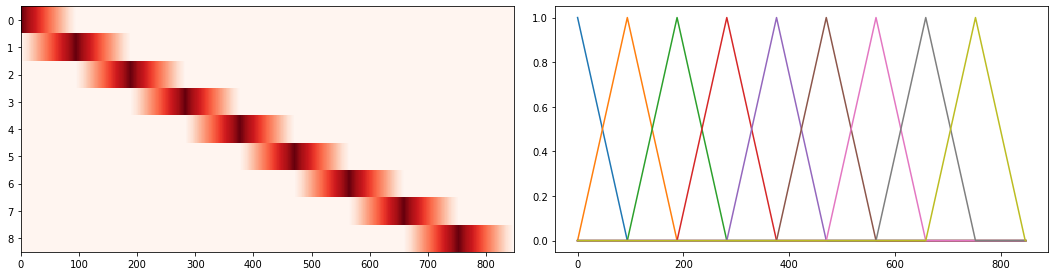

In [15]:
Xdrift, num_drifts = utils.drift_design_matrix( num_trials, anchor_spacing )
utils.subplot_setup(1,2, row_height=4, full_width=True)
plt.subplot(121)
plt.imshow(Xdrift.T, aspect='auto', interpolation='none', cmap='Reds')
plt.subplot(122)
plt.plot(Xdrift)
plt.show()

Linear multiplication by a length-8 vector (in this case) will result in a term that extends over the 848 trials with the values at each 'anchor point' determined by this vector, and linear interpolation in between. 

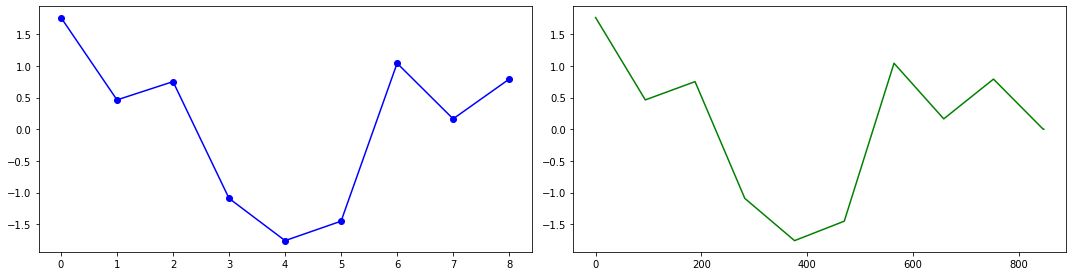

In [16]:
k = np.random.normal(size=num_drifts)
kfull = Xdrift@k
utils.subplot_setup(1,2, row_height=4, full_width=True)
plt.subplot(121)
plt.plot(k,'b')
plt.plot(k,'bo')
plt.subplot(122)
plt.plot(kfull,'g')
plt.show()

We additional impose a smoothness penalty on the values of the drift term (see above/below -- not shown here), 
and leave out the last tent-basis element to fix the last values to have zero offset.

### Appendix 2: illustration of Laplacian regularization matrices for smoothness

We use a standard "smoothness" regularization to enforce small changes in slope (see for example McFarland PLoS CB 2013). For a given tuning curve $f(x)$ (for example), this term can explicitly be written:
<br>
\begin{equation}
\mbox{penalty} = \lambda \sum_x \left[ 2f(x)-f(x-1)-f(x+1) \right]^2
\end{equation}
<br>
We implement this using a (Tikhonov) matrix $\mathbf{T}$ that acts on the weights as a whole:
<br>
\begin{equation}
\mbox{penalty} = \lambda |\mathbf{T} k |^2
\end{equation}
<br>
where $\mathbf{T}$ is a Laplacian matrix with the edges zeroed-out (using our function defined above):

In [17]:
print(laplacian_smoothness_matrix(ND))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
